In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # Cambiar cu118 por la versión de Cuda del sistema
!pip install ipywidgets widgetsnbextension torchsummary einops tqdm matplotlib
!pip install -U "jax[cuda12]"  # Cambiar cuda11 por la versión de nuestro CUDA
!pip install flax
!pip install -q clu

# PRÁCTICA 1: MODELOS DE DIFUSION Y MECANISMOS DE ATENCIÓN

En esta práctica veremos como podemos definir una de las arquitecturas más novedosas en el campo de las redes neuronales: los **__modelos de difusión__**.

En esencia, un modelo de difusión aprende a generar datos similares a una entrada a partir de imágenes con puro ruido. Este tipo de modelos se han vuelto muy populares en la generación de imágenes como DALL-E de OpenAI.

Los principales conceptos que cubriremos con esta práctica son los siguientes:
 - Definir modelos de difusión
 - Arquitectura U-NET
 - Mecanismos de atención basados en __visual transformers__

Antes de comenzar con el modelo, vamos a importar las librerías que necesitaremos:

In [44]:
!jupyter nbextension enable --py widgetsnbextension

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


/home/dherreros/miniforge3/envs/pytorch/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


A diferencia de la **Práctica 4**, aquí veremos como usar las funciones de compilación de código en __JAX__ y __XLA__ para mejorar aún la eficiencia de nuestras redes.

In [45]:
import os
from typing import List
import shutil

# Librerías de JAX
import jax
from jax import random as jnr, numpy as jnp
from jax.tree_util import tree_map
from flax import linen as nn
import optax
from flax.training import train_state
import orbax.checkpoint
from flax.training import orbax_utils
from flax.struct import field

# Una librería muy util para ajustar los tamaños de nuestros tensores
from einops import rearrange

# Torch vision para descargar y preprocesar el conjunto de datos que usaremos para entrenar la red
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, default_collate

# Herramientas adicionales para la visualización de los datos y resultados
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

Durante esta práctica usaremos de nuevo el conjunto de datos `FashionMNIST` para entrenar la red. Comenzaremos por descargar y generar el `DataLoader` para poder enviar datos a la red de manera eficiente.

Dado que vamos a aprovechar el ``DataLoader`` de __PyTorch__ en __JAX__, necesitamos convertir nuestros lotes a __Numpy__ par que __JAX__ pueda trabajar con los datos. Esto lo haremos usando la funcionalidad ``collate_fn`` del ``DataLoader`` junto con una función que se encargue de hacer esta conversión:

In [46]:
def numpy_collate(batch):
  """
  Esta funión determina como combinar una lista de muestras en un lote.
  default_collate crea tensores de PyTorch, y tree_map se encarga de convertirlos a numpy arrays.
  """
  return tree_map(np.asarray, default_collate(batch))

train_dataset = datasets.FashionMNIST("./MNIST_DATA", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0, collate_fn=numpy_collate)

Vamos a definir también el dispositivo que usaremos para procesar (GPU):

In [47]:
DEVICE = jax.devices('gpu')[0]

Inspección de los datos de entrenamiento: 
Tamaño del lote:  (64, 28, 28, 1)


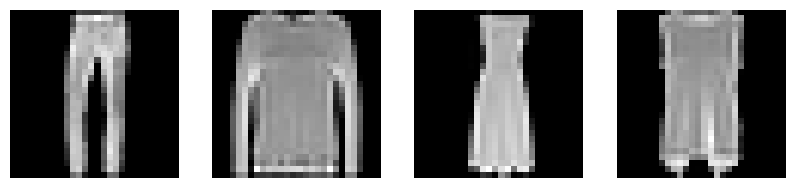

In [48]:
print("Inspección de los datos de entrenamiento: ")
for _, data in enumerate(train_loader):
    x = rearrange(data[0], 'b c w h -> b w h c')
    print("Tamaño del lote: ",x.shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        ax[i].imshow(x[i].squeeze(), cmap="gray")
        ax[i].axis("off")
    plt.show()
    # Hacemos break para no recorrer todo el loader
    break

Antes de definir nuestra red, vamos a generar un embedding sinusoidal. Este tipo de embeddings permiten transmitir el concepto de "secuencia" a nuestros datos:

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*DEZ4oDAZm0RCOPDb.png" width=500, heigh=500 />

En nuestro caso, los usaremos para definir diferentes momentos en el tiempo: cuando nuestro tiempo sea igual a 0, tendremos imágenes compuestas completamente por ruido. A medida que el tiempo avance, nuestras imágenes iran perdiendo ruido y ganando señal hasta llegar a una imagen limpia del objeto de interés. Por lo tanto, este concepto de tiempo no deja de ser una secuencia de pasos, teniendo cada uno una cantidad de ruido menor.


In [49]:
class SinusoidalEmbeddings(nn.Module):
    time_steps: int
    embed_dim: int

    def setup(self):
        position = jnp.arange(self.time_steps, dtype=jnp.float32)[:, None]
        div = jnp.exp(jnp.arange(0, self.embed_dim, 2, dtype=jnp.float32) * -(jnp.log(10000.0) / self.embed_dim))
        embeddings = jnp.zeros((self.time_steps, self.embed_dim))
        embeddings = embeddings.at[:, 0::2].set(jnp.sin(position * div))
        embeddings = embeddings.at[:, 1::2].set(jnp.cos(position * div))
        self.embeddings = jnp.array(embeddings)

    def __call__(self, t):
        embeds = self.embeddings[t]
        return embeds[:, None, None, :]

Una vez definidos nuestro embedding con sentido de secuencia, podemos comenzar a instanciar nuestra U-NET. En primer lugar, comenzaremos por definir el bloque esencial que compone este tipo de redes: un conjunto de capas convolucionales con conexiones residuales:

In [50]:
class ResBlock(nn.Module):
    C: int
    num_groups: int
    dropout_prob: float

    def setup(self):
        self.relu = nn.relu
        self.gnorm1 = nn.GroupNorm(num_groups=self.num_groups)  # Esta capa normaliza los canales dividiendolas previamente en pequeños grupos
        self.gnorm2 = nn.GroupNorm(num_groups=self.num_groups)  # Esta capa normaliza los canales dividiendolas previamente en pequeños grupos
        self.conv1 = nn.Conv(self.C, kernel_size=(3, 3), strides=(1, 1), padding="SAME")
        self.conv2 = nn.Conv(self.C, kernel_size=(3, 3), strides=(1, 1), padding="SAME")
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, embeddings, train):
        x = x + embeddings[:, :, :, :x.shape[-1]]  # Embeddings vendrá definido por SinusoidalEmbeddings en un "momento" determinado de la secuencia de tiempo
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r, deterministic=not train)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

<img src="https://api.wandb.ai/files/wandb_fc/images/projects/605819/472b8f50.png" width=500, heigh=500 />


Una vez definido el bloque esencial de nuezstra U-NET, podemos pasar a definir cada capa de nuestra red neuronal. Estas capas estarán compuestas por dos bloques residuales (previamente definidos), una capa de atención basada en transformadores visuales, y una capa de convolución/convolución transpuesta (esto dependerá de si esta capa se encuentra en la primera o en la segunda mitad de nuestra U-NET tal y como veremos más adelante):

In [51]:
class UnetLayer(nn.Module):
    upscale: bool
    attention: bool
    num_groups: int
    dropout_prob: float
    num_heads: int
    C: int

    def setup(self):
        self.ResBlock1 = ResBlock(C=self.C, num_groups=self.num_groups, dropout_prob=self.dropout_prob)
        self.ResBlock2 = ResBlock(C=self.C, num_groups=self.num_groups, dropout_prob=self.dropout_prob)
        if self.upscale:
            # Primera opción: Operación de convolución tranpuesta "similar" a PyTorch
            self.conv = nn.ConvTranspose(self.C // 2, kernel_size=(4, 4), strides=(2, 2), transpose_kernel=True, padding="SAME")

            # Segunda opción: Incrementar el tamaño de la imagen y después hacer una convolución estandar
            # self.conv = nn.Conv(self.C // 2, kernel_size=(4, 4), strides=(1, 1), padding="SAME")
        else:
            self.conv = nn.Conv(self.C * 2, kernel_size=(3, 3), strides=(2, 2), padding="SAME")
        if self.attention:
            self.attention_layer = Attention(self.C, num_heads=self.num_heads, dropout_prob=self.dropout_prob)

    def __call__(self, x, embeddings, train):
        x = self.ResBlock1(x, embeddings, train)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x, train)
        x = self.ResBlock2(x, embeddings, train)
        # if self.upscale:
        #     x_conv = jax.image.resize(x, (x.shape[0], 2 * x.shape[1], 2 * x.shape[2], x.shape[3]),  method='nearest')
        #     x_conv = self.conv(x_conv)
        # else:
        #     x_conv = self.conv(x)
        x_conv = self.conv(x)
        return x_conv, x

Para completar la capa de nuestra U-NET, tenemos que definir la capa con mecanismo de atención. Para más información sobre el mecanismo de funcionamiento de esta capa, es recomendable dirigirse a las diapositivas teóricas del curso.

A modo de resumen, la capa de atención se basa en calcular una sería de matrices entrenables a partir de los inputs:
 - Capa **Q** (Queries): Representa el conjunto de elementos a partir de los cuales calcularemos la atención.
 - Capa **K** (Keys): Una capa que contiene "identificadores" para un determinado valor. Se usa en conjunto con la capa **Q** para determinar cuanta atención hay que prestar a cada valor.
 - Capa **V** (Values): Esta capa contiene los valores con información (es decir, nuestro input) a los que aplicaremos la atención previamente calculada.

Nuestra capa de atención calculará las matrices Q, K y V a partir de los inputs de la capa, aplicando una capa densa (que se puede entender como una proyección de los inputs en base a una matriz entrenable). Previamente a este cálculo, redimensionaremos nuestro input fusionando las dimensiones espaciales de la imagen (generando así una secuencia 1D sobre la que aplicar la atención) y dejando la capa de canales como una capa auxiliar para calcular las features necesarias para derivar las matrices Q, K y V.

Una vez calculadas estas matrices, calcularemos la atención de acuerdo a la fórmula:

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*sXEtwjKCACQ6yfW5T8UolQ.png" width=500, heigh=500 />


In [52]:
class Attention(nn.Module):
    C: int
    num_heads: int
    dropout_prob: float

    def setup(self):
        self.proj1 = nn.Dense(self.C * 3)
        self.proj2 = nn.Dense(self.C)

    def __call__(self, x, train):
        # rng = jnr.key(random.randint(0, 2**32-1))

        h, w = x.shape[1], x.shape[2]
        x = rearrange(x, 'b h w c -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        # x = nn.dot_product_attention(q, k, v, dropout_rate=self.dropout_prob, dropout_rng=rng, deterministic=not train)
        x = nn.dot_product_attention(q, k, v)
        x = rearrange(x, 'b H (h w) C -> b h w (H C)', h=h, w=w)
        x = self.proj2(x)
        return x

A partir de las capas previamente definidas, podemos construir nuestra U-Net. Una arquitectura U-NET se basa en una serie de capas simétricas de submuestreado y escalado con conexiones residuales, de tal manera que la salida de la red tenga el mismo tamaño que los datos de entrada. Nuestra clase incluirá un conjunto de listas que nos permitirán definir tanto el número de capas de nuestra U-Net como el encrustamiento de capas de atención solo en determinadas capas.

In [53]:
class UNET(nn.Module):
    Channels: List[int] = field(default_factory=lambda: [64, 128, 256, 512, 512, 384])
    Attentions: List[bool] = field(default_factory=lambda: [False, True, False, False, False, True])
    Upscales: List[bool] = field(default_factory=lambda: [False, False, False, True, True, True])
    num_groups: int = 32
    dropout_prob: float = 0.1
    num_heads: int = 8
    output_channels: int = 1
    time_steps: int = 1000

    def setup(self):
        self.num_layers = len(self.Channels)
        self.shallow_conv = nn.Conv(self.Channels[0], kernel_size=(3, 3), strides=(1, 1), padding="SAME")
        out_channels = (self.Channels[-1] // 2) + self.Channels[0]
        self.late_conv = nn.Conv(out_channels // 2, kernel_size=(3, 3), strides=(1, 1), padding="SAME")
        self.output_conv = nn.Conv(self.output_channels, kernel_size=(1, 1), strides=(1, 1), padding="VALID")
        self.relu = nn.relu
        self.embeddings = SinusoidalEmbeddings(time_steps=self.time_steps, embed_dim=max(self.Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=self.Upscales[i],
                attention=self.Attentions[i],
                num_groups=self.num_groups,
                dropout_prob=self.dropout_prob,
                C=self.Channels[i],
                num_heads=self.num_heads,
            )
            setattr(self, f'Layer{i+1}', layer)


    def __call__(self, x, t, train):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(t)
            x, r = layer(x, embeddings, train)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = jnp.concat((layer(x, embeddings, train)[0], residuals[self.num_layers-i-1]), axis=-1)
        return self.output_conv(self.relu(self.late_conv(x)))

En este punto, tenemos nuestra red completamente definida y lista para ser entrenada. Sin embargo, aún no tenemos un método para corromper nuestras imágenes con diferentes niveles de ruido dependiendo del momento en el "tiempo" en el que se encuentren nuestras imágenes. Recordemos que este "momento en el tiempo" hacer referencia al nivel de ruido en las imágenes (siendo t=0 el momento en el que solo hay ruido y t=N el momento en el que nuestra imagen no tiene ruido).

Para ello, vamos a definir un ``Scheduler``, el cual nos permitirá recuperar los parámetros necesarios para recuperar el nivel de ruido que corromperá a la imagen en cada momento en el tiempo:

In [54]:
class DDPM_Scheduler:
    def __init__(self, num_time_steps: int=1000):
        self.beta = jnp.linspace(1e-4, 0.02, num_time_steps)
        alpha = 1 - self.beta
        self.alpha = jnp.cumprod(alpha, axis=0)

    def __call__(self, t):
        return self.beta[t], self.alpha[t]

Una vez definidos todos los componentes necesarios para entrenar la red, podemos proceder con la instanciación del loop de entrenamiento. En ese caso, lo encapsularemos dentro de una función para que sea más sencillo de ejecutar en diferentes scripts.

Nuestra función de entrenamiento recibirá como input los principales hiperparámetros a controlar para asegurar que el entrenamiento se ajusta a nuestro requirimientos de hardware. Estos parámetros incluyen:

- Número de "momentos en el tiempo" (**num_time_steps**): Permite determinar cuantos niveles de ruido habrá entre el primer momento en el tiempo (imagen formada solo por ruido) y el tiempo final (imagen sin ruido)
- Número de epochs (**num_epochs**): Permite modificar el número de veces que se recorre el conjunto de entrenamiento
- Archivo de punto de guardado (**checkpoint_path**): Permite dar el path a un archivo dónde iremos guardando el estado de la red a medida que el entrenamiento avanza. Esto es muy útil sobre todo cuando el proceso de entrenamiento es largo o queremos analizar el estado de la red en algún punto intermedio del entrenamiento, permitiéndonos recargar el estado de la red en ese punto para hacer inferencia o continuar el entrenamiento desde ese punto.

In [55]:
def init_train_state(model, random_key, dummy_input, learning_rate) -> train_state.TrainState:
    # Inicialización del modelo
    variables = model.init(random_key, *dummy_input)

    # Optimizador
    optimizer = optax.adam(learning_rate)

    # Creación del estado
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

@jax.jit
def train_step(train_state, alpha, x, t, e, random_key) -> train_state.TrainState:
    def loss_fn(params):
        a = alpha[t][:, None, None, None]
        x_noisy = (jnp.sqrt(a) * x) + (jnp.sqrt(1 - a) * e)
        output = train_state.apply_fn({'params': params}, x_noisy, t, True, rngs={'dropout': random_key})
        loss = jnp.mean((output - e) ** 2)
        return loss

    gradient_fn = jax.value_and_grad(loss_fn)
    loss, grads = gradient_fn(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)

    return train_state, loss


def train(batch_size: int=64,
          num_time_steps: int=1000,
          num_epochs: int=15,
          lr=2e-5,
          checkpoint_path: str=None):

    train_dataset = datasets.FashionMNIST("./MNIST_DATA", train=True, download=True,transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0, collate_fn=numpy_collate)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    rng = jnr.key(random.randint(0, 2**32-1))  # En JAX hay que instanciar una random seed manualmente
    rng, model_key = jax.random.split(rng, 2)

    model = UNET()
    state = init_train_state(model, model_key, [jnp.zeros((1, 32, 32, 1)), jnp.array([0], dtype=jnp.int32), True], lr)

    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {i + 1}/{num_epochs}")):
            rng, t_key, noise_key, step_key = jnr.split(rng, 4)
            x = rearrange(x, 'b c w h -> b w h c')
            x = jnp.pad(x, ((0, 0), (2, 2), (2, 2), (0, 0)))
            t = jnr.randint(minval=0, maxval=num_time_steps, shape=(batch_size,), key=t_key)
            e = jnr.normal(shape=x.shape, key=noise_key)
            # a = scheduler.alpha[t][:, None, None, None]
            # x = (jnp.sqrt(a) * x) + (jnp.sqrt(1 - a) * e)
            state, loss = train_step(state, scheduler.alpha, x, t, e, step_key)
            total_loss += loss
        print(f'Epoch {i + 1} | Loss {total_loss / (60000 / batch_size):.5f}')

    checkpoint = {
        'model': state,
    }

    if checkpoint_path is not None:
        orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        save_args = orbax_utils.save_args_from_target(checkpoint)
        orbax_checkpointer.save(os.path.abspath(os.path.join(checkpoint_path, "checkpoint")), checkpoint, save_args=save_args)

El siguiente paso consiste en entrenar nuestra red usando la función anterior:

In [56]:
    if os.path.isdir(os.path.join('checkpoints')):
        shutil.rmtree(os.path.join('checkpoints'))
    train(checkpoint_path=os.path.join('checkpoints', 'ddpm_checkpoint_jax'), lr=1e-4, num_epochs=5)

Epoch 1/5: 100%|██████████| 937/937 [02:48<00:00,  5.55it/s]


Epoch 1 | Loss 0.10118


Epoch 2/5: 100%|██████████| 937/937 [02:37<00:00,  5.96it/s]


Epoch 2 | Loss 0.04491


Epoch 3/5: 100%|██████████| 937/937 [02:40<00:00,  5.83it/s]


Epoch 3 | Loss 0.03493


Epoch 4/5: 100%|██████████| 937/937 [02:42<00:00,  5.77it/s]


Epoch 4 | Loss 0.03006


Epoch 5/5: 100%|██████████| 937/937 [02:49<00:00,  5.54it/s]


Epoch 5 | Loss 0.02722


Una vez hayamos entrenado la red, podemos aprovechar nuestro archivo ``checkpoint.pth`` para recargarla y hacer inferencia de nuestro conjunto de datos para así comprobar si la red es capaz de regenerar nuestras imágenes a partir de puro ruido. Para ello, definiremos en primer lugar una función para representar las imágenes que se generen desde la red.

In [57]:
def display_reverse(images: List, times: List=None, save_gif=True):
    if times is not None:
        t = 0

    if save_gif:
        frames = []
        fig, ax = plt.subplots()
        for i in range(len(images)):
            x = images[i].squeeze()
            im = ax.imshow(x, animated=True, cmap="Grays_r")
            if i == 0:
                ax.imshow(x, cmap="Grays_r")
            if times is not None:
                ax.set_title("Time: " + str(times[t]))
                t += 1
            ax.axis('off')
            fig.tight_layout()
            frames.append([im])
        ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
                                        repeat_delay=1000)
        writer = animation.PillowWriter(fps=2, bitrate=1800)
        ani.save(f"diffusion_model_example.gif", writer=writer)
    else:
        fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
        for i, ax in enumerate(axes.flat):
            x = images[i].squeeze()
            ax.imshow(x, cmap="Grays")
            if times is not None:
                ax.set_title("Time: " + str(times[t]))
                t += 1
            ax.axis('off')
        fig.tight_layout()
        plt.show()

A continuación definiremos una nueva función que nos permitirá hacer inferencia con la red. Esta función aprovechará el archivo ``checkpoint.pth`` para recargar el estado de la red y así poder utilizarla para predecir imágenes a partir de puro ruido.

Para ello, aprovecharemos nuestro ``DDPM_Scheduler`` para generar los parámetros que necesitaremos para generar los diferentes niveles de ruido. De manera intuitiva, el proceso de inferencia es exactamente igual al de entrenamiento pero en sentido opuesto: empezaremos con imágenes de ruido y progresivamente la red irá disminuyendo el ruido hasta conseguir una imagen única que se parezca a las imágenes de entrenamiento. Cada vez que generemos una nueva imagen de ruido, obtendremos una imagen única diferente.

In [58]:
@jax.jit
def eval_step(state, x, t):
    y = state.apply_fn({'params': state.params}, x, t, False)
    return y

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000):

    rng = jnr.key(random.randint(0, 2**32-1))  # En JAX hay que instanciar una random seed manualmente
    rng, model_key = jax.random.split(rng, 2)

    model = UNET()
    variables = model.init(model_key, *[jnp.zeros((1, 32, 32, 1)), jnp.array([0], dtype=jnp.int32), True])
    state = train_state.TrainState.create(apply_fn=model.apply, params=jax.tree_util.tree_map(np.zeros_like, variables['params']), tx=optax.adam(1.))

    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    target = {'model': state,}
    state = orbax_checkpointer.restore(os.path.abspath(os.path.join(checkpoint_path, "checkpoint")), item=target)["model"]

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    for i in range(1):
        rng, img_rng = jnr.split(rng, 2)
        z = jnr.normal(key=rng, shape=(1, 32, 32, 1))
        for t in reversed(range(1, num_time_steps)):
            img_rng, noise_key = jnr.split(img_rng, 2)
            t = jnp.array([t])
            temp = (scheduler.beta[t] / ( (jnp.sqrt( 1 - scheduler.alpha[t])) * (jnp.sqrt(1 - scheduler.beta[t]))))
            z = (1 / (jnp.sqrt(1 - scheduler.beta[t]))) * z - (temp * eval_step(state, z, t))
            if t[0] in times:
                images.append(np.array(z))
            e = jnr.normal(key=noise_key, shape=(1, 32, 32, 1))
            z = z + (e * jnp.sqrt(scheduler.beta[t]))
        temp = scheduler.beta[0] / ((jnp.sqrt(1 - scheduler.alpha[0])) * (jnp.sqrt(1 - scheduler.beta[0])))
        x = (1 / (jnp.sqrt(1 - scheduler.beta[0]))) * z - (temp * eval_step(state, z, jnp.array([0])))

        images.append(np.array(x))
        display_reverse(images, times=list(reversed(times)))
        images = []

A continuación, probaremos la capacidad de inferencia de la red:

/home/dherreros/miniforge3/envs/pytorch/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


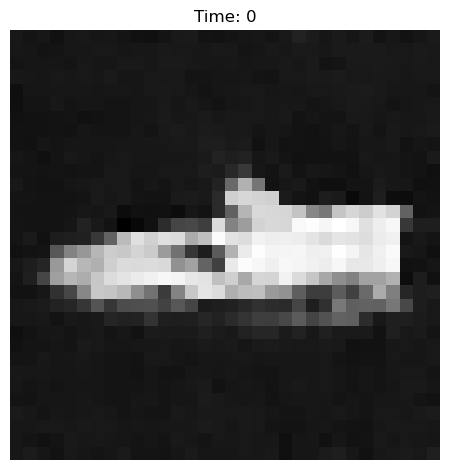

In [59]:
inference(os.path.join('checkpoints', 'ddpm_checkpoint_jax'))

<img src="diffusion_model_example.gif" width=500, heigh=500 />